# E2a: Küchentischversuch zum Laval-Rotor

Name:  Sommer, Luca
Datum:  15.12.2023

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit:
Wie gut kann man die Bewegungen eines Haushaltsgerätes mit einem Beschleunigungssensor in einem Küchentischversuch aufnehmen? Kommt es zu nicht erwarteten Messfehlern und starken Abweichungen? Woraus könnten entsprechende Abweichungen oder Fehler resultieren?

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

![Versuch1](figures/Versuch1.jpg)

- Beschreibung des Aufbaus: Der Sensor wird, isoliert von Klebeband, an der Rückseite des Ventilators befestigt und  mit dem Raspberry Pi verbunden. Eine Rotationsbewegung des Ventilators ist immernoch möglich. Alle notwendigen Geräte werden mit dem Strom verbunden. 
- Vorgangsbeschreibung: Nachdem alle Geräte angeschlossen sind, wird der Ventilator eingeschaltet, sodass sich dieser beginnt zu bewegen. Nun startet man die Messung und wartet die entsprechende Messdauer ab. Danach schaut man sich die gemessen Werte in der HDF5 Datei an und überprüft, ob diese plausibel sind. Wenn dies der Fall ist, ist der Versuch damit schon korrekt durchgeführt.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [1]:
import h5py as h5
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [2]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# Angabe des Dateipfades zur entsprechenden HDF5 Datei der vorliegenden Messung des Objektes.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = 'measurement_data' 
h5_file_name = 'data_20231215_085412_YourNameWithoutWhiteSpaces_ventilator.h5' 
# ---------------------------------------------------------------------------------------------#1-end

In [3]:
# Ausgabe der Infos aus den JSON-Files zum Beschleunigungssensor und der entsprechenden Probe.
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20231215_085412_YourNameWithoutWhiteSpaces_ventilator/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20231215_085412_YourNameWithoutWhiteSpaces_ventilator/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20231215_085412_YourNameWithoutWhiteSpaces_ventilator/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1ee99054-4efc-64d2-83e6-faf97a4fdf99": {
    "type": "probe",
    "name": "ventil

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [4]:
# Auslesen der drei Beschleunigungen und der zur Messung notwendigen Zeitschritte.
path = 'measurement_data/data_20231215_085412_YourNameWithoutWhiteSpaces_ventilator/data_20231215_085412_YourNameWithoutWhiteSpaces_ventilator.h5'
file = h5.File(path, 'r')

data = file['1ee847be-fddd-6ee4-892a-68c4555b0981']
        
time = np.array(data['timestamp'])
acceleration_x = np.array(data['acceleration_x'])
acceleration_y = np.array(data['acceleration_y'])
acceleration_z = np.array(data['acceleration_z'])

#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [5]:
# Betrag der Beschleunigung bilden
betrag_acceleration = get_vec_accel(acceleration_x, acceleration_y, acceleration_z)

#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

Text(0, 0.5, 'Differenz der Zeitschritte')

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


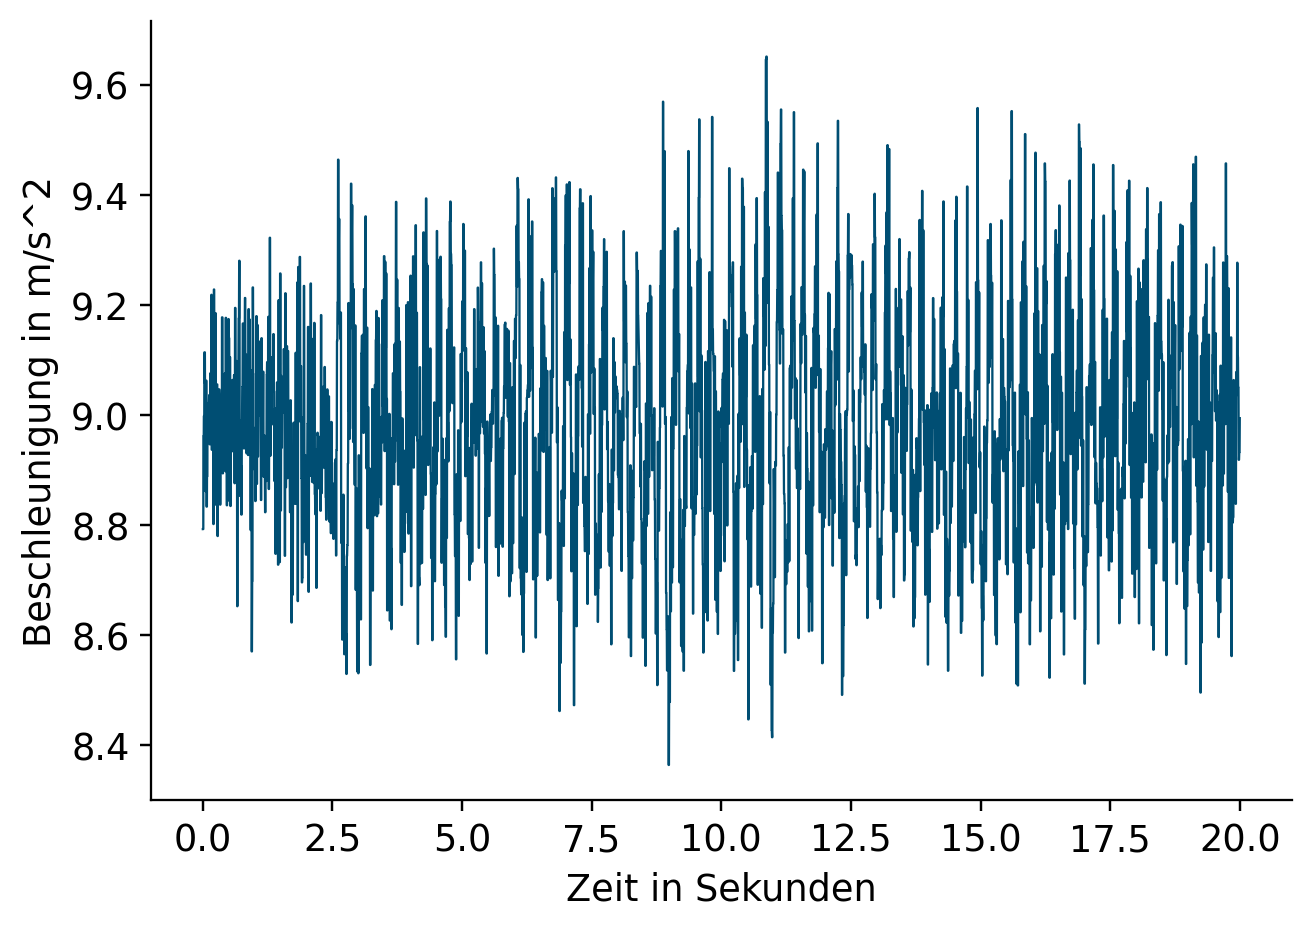

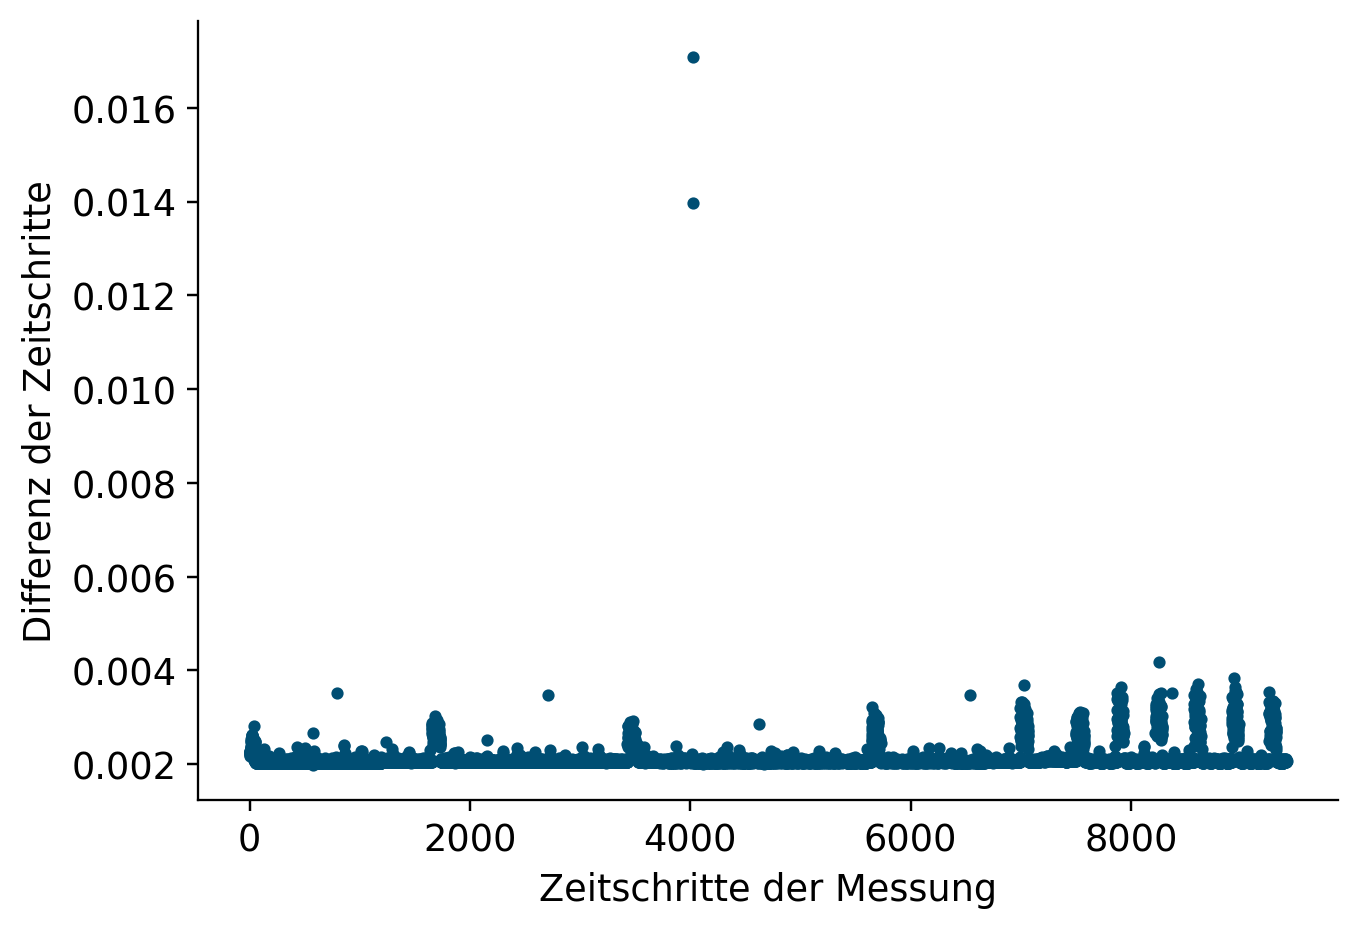

In [6]:
# Plotten der Beschleunigung über der Zeit und der Differenz der Zeitschritte über der Zeit.
fig = plt.figure()
plt.plot(time, betrag_acceleration)
plt.xlabel('Zeit in Sekunden')
plt.ylabel('Beschleunigung in m/s^2')

delta_t_liste = []
for i in range(1, (len(time))):
    delta_t_liste.append(time[i] - time[i-1])
    
fig2 = plt.figure()
plt.plot(delta_t_liste, '.')
plt.xlabel('Zeitschritte der Messung')
plt.ylabel('Differenz der Zeitschritte')

#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [7]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.
# Beschleunigungsdaten interpolieren, damit man diese später für die Fouriertransformation nutzen kann.
daten_interpoliert = interpolation(time, betrag_acceleration)

#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

Text(0, 0.5, 'Amplitude der interpolierten Messdaten')

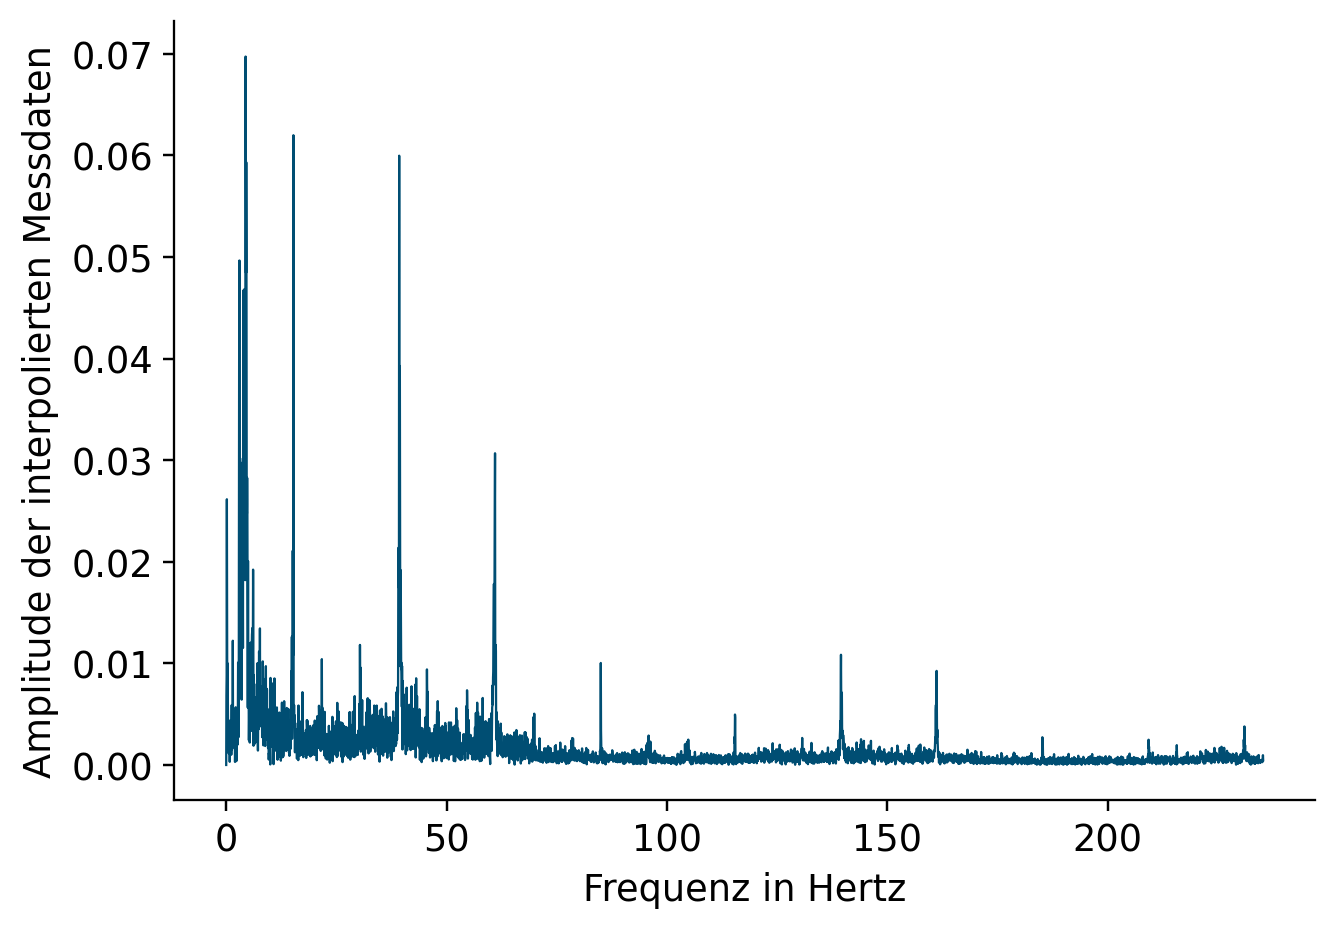

In [8]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.
# Ausgabe der fertig bearbeiteten Fouriertransformation.
X_oneside, f_oneside = my_fft(daten_interpoliert, time)

fig2 = plt.figure()
plt.plot(f_oneside, np.abs(X_oneside))
plt.xlabel('Frequenz in Hertz')
plt.ylabel('Amplitude der interpolierten Messdaten')
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

![Versuch1](figures/Versuch2.jpg)

- Beschreibung des Aufbaus: Der Bewegungssensor wird an der Seite der Brotschneidemaschine befestigt, um die Bewegungen der Maschine während des Betriebs aufzunehmen. Der Sensor wird mit dem Raspberry Pi verbunden und alle Geräte werden an den Strom angeschlossen.
- Vorgangsbeschreibung: Nachdem der Sensor befestigt ist, startet man die Brotschneidemaschine. Nun startet man die Messung und wartet die entsprechende Messdauer ab. Auch hiernach überprüft man die Daten auf Plausibilität. Ist diese gegeben, ist der Versuch beendet. 

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [9]:
path_measurement_folder = 'measurement_data'
h5_file_name = 'data_20231215_084206_YourNameWithoutWhiteSpaces_brotschneidemaschine.h5'

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [10]:
path = 'measurement_data/data_20231215_084206_YourNameWithoutWhiteSpaces_brotschneidemaschine/data_20231215_084206_YourNameWithoutWhiteSpaces_brotschneidemaschine.h5'
# Lese die Daten aus der HDF5-Datei
file = h5.File(path, 'r')

data = file['1ee847be-fddd-6ee4-892a-68c4555b0981']
        
time = np.array(data['timestamp'])
acceleration_x = np.array(data['acceleration_x'])
acceleration_y = np.array(data['acceleration_y'])
acceleration_z = np.array(data['acceleration_z'])

#### 2. Betrag der Beschleunigung berechnen


In [11]:
betrag_acceleration = get_vec_accel(acceleration_x, acceleration_y, acceleration_z)

#### 3. Darstellung der Messdaten

Text(0, 0.5, 'Differenz der Zeitschritte')

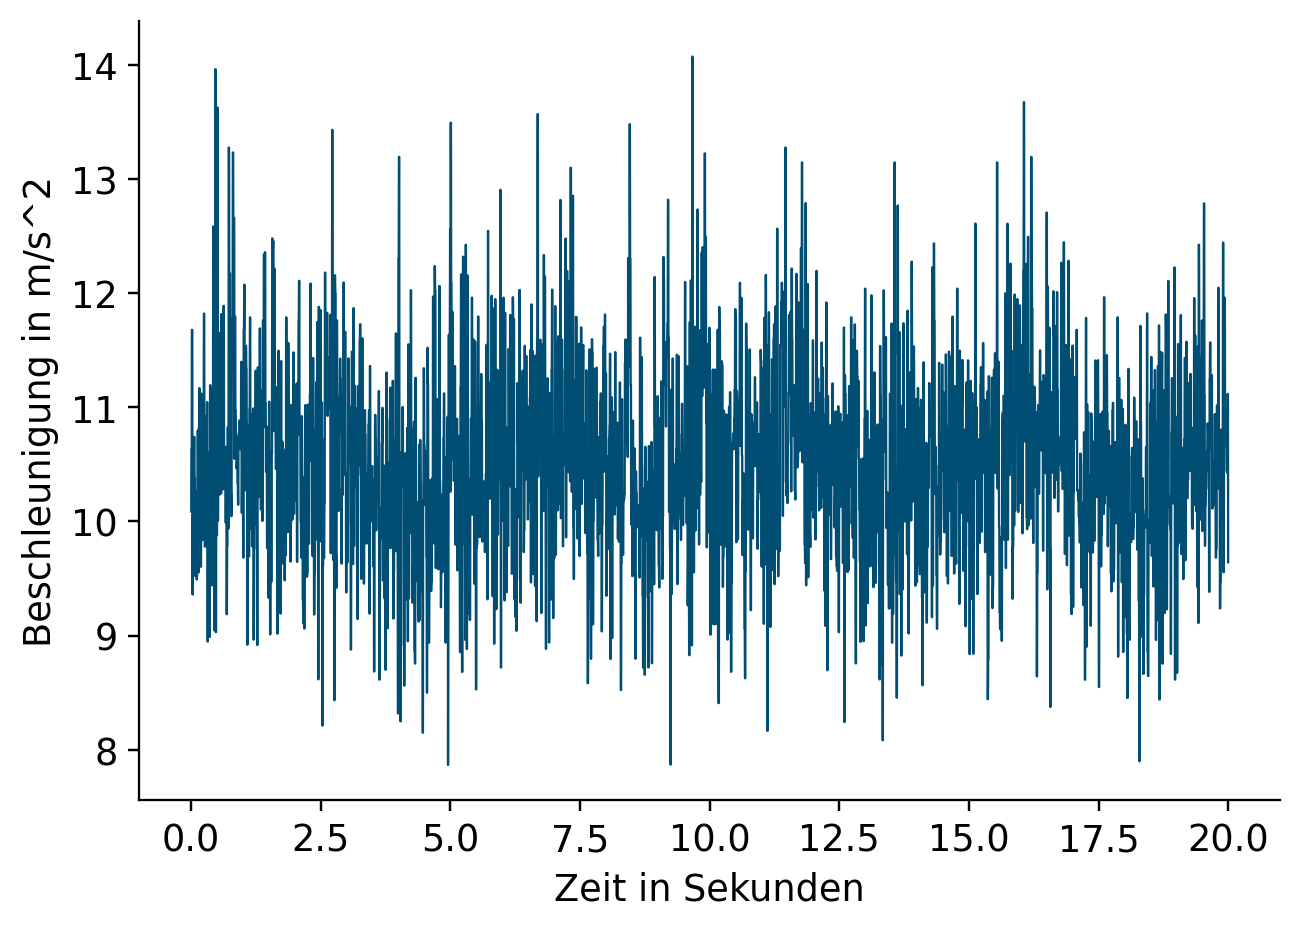

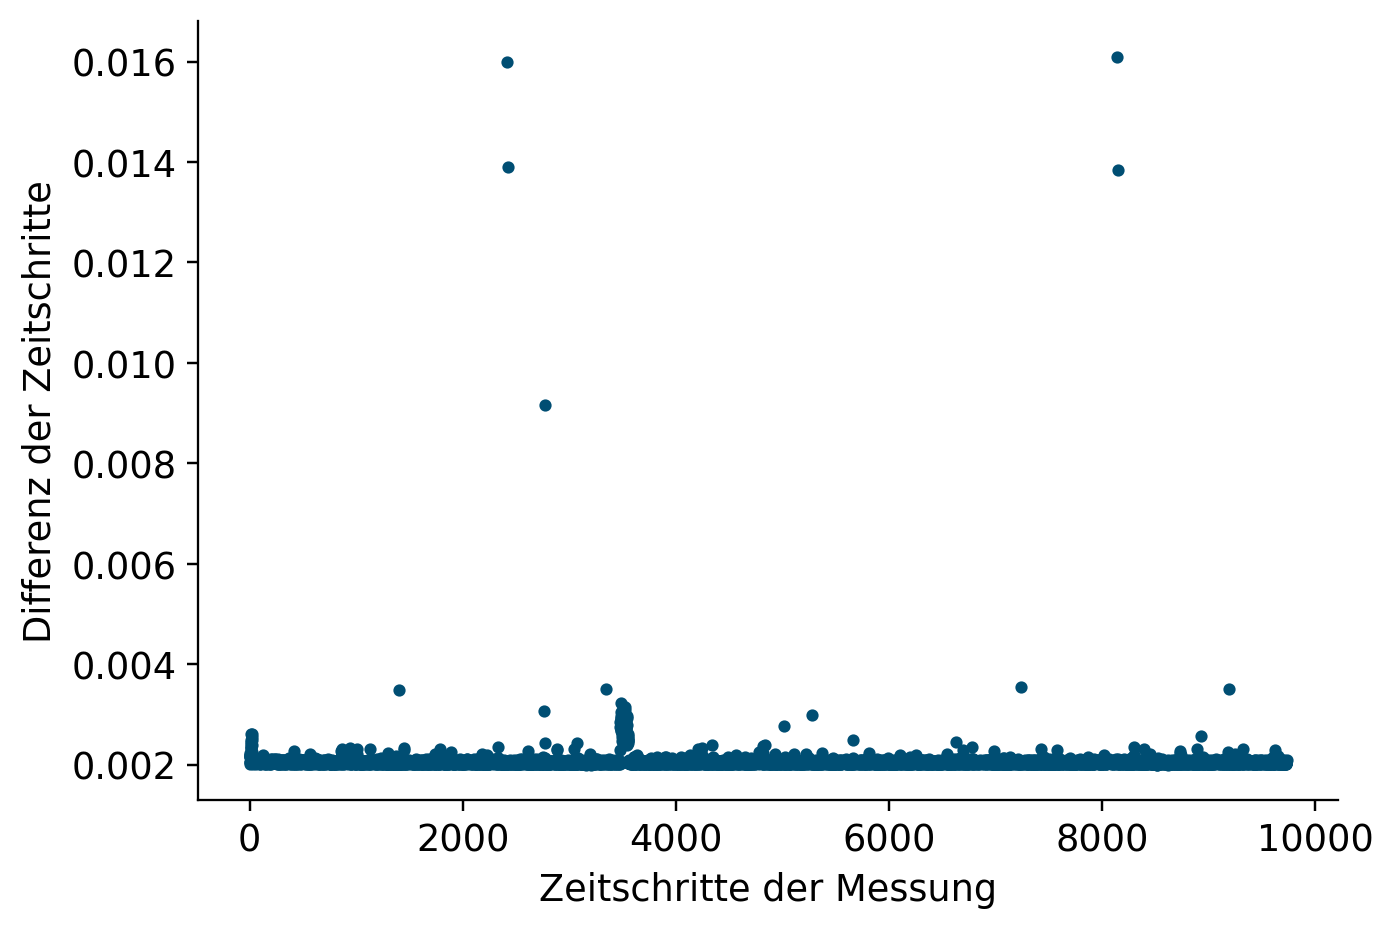

In [12]:
fig = plt.figure()
plt.plot(time, betrag_acceleration)
plt.xlabel('Zeit in Sekunden')
plt.ylabel('Beschleunigung in m/s^2')

delta_t_liste = []
for i in range(1, (len(time))):
    delta_t_liste.append(time[i] - time[i-1])
    
fig2 = plt.figure()
plt.plot(delta_t_liste, '.')
plt.xlabel('Zeitschritte der Messung')
plt.ylabel('Differenz der Zeitschritte')

#### 4. Interpolation der Messwerte



In [13]:
daten_interpoliert = interpolation(time, betrag_acceleration)

#### 5 & 6. FFT durchführen und graphisch darstellen


Text(0, 0.5, 'Amplitude der interpolierten Messdaten')

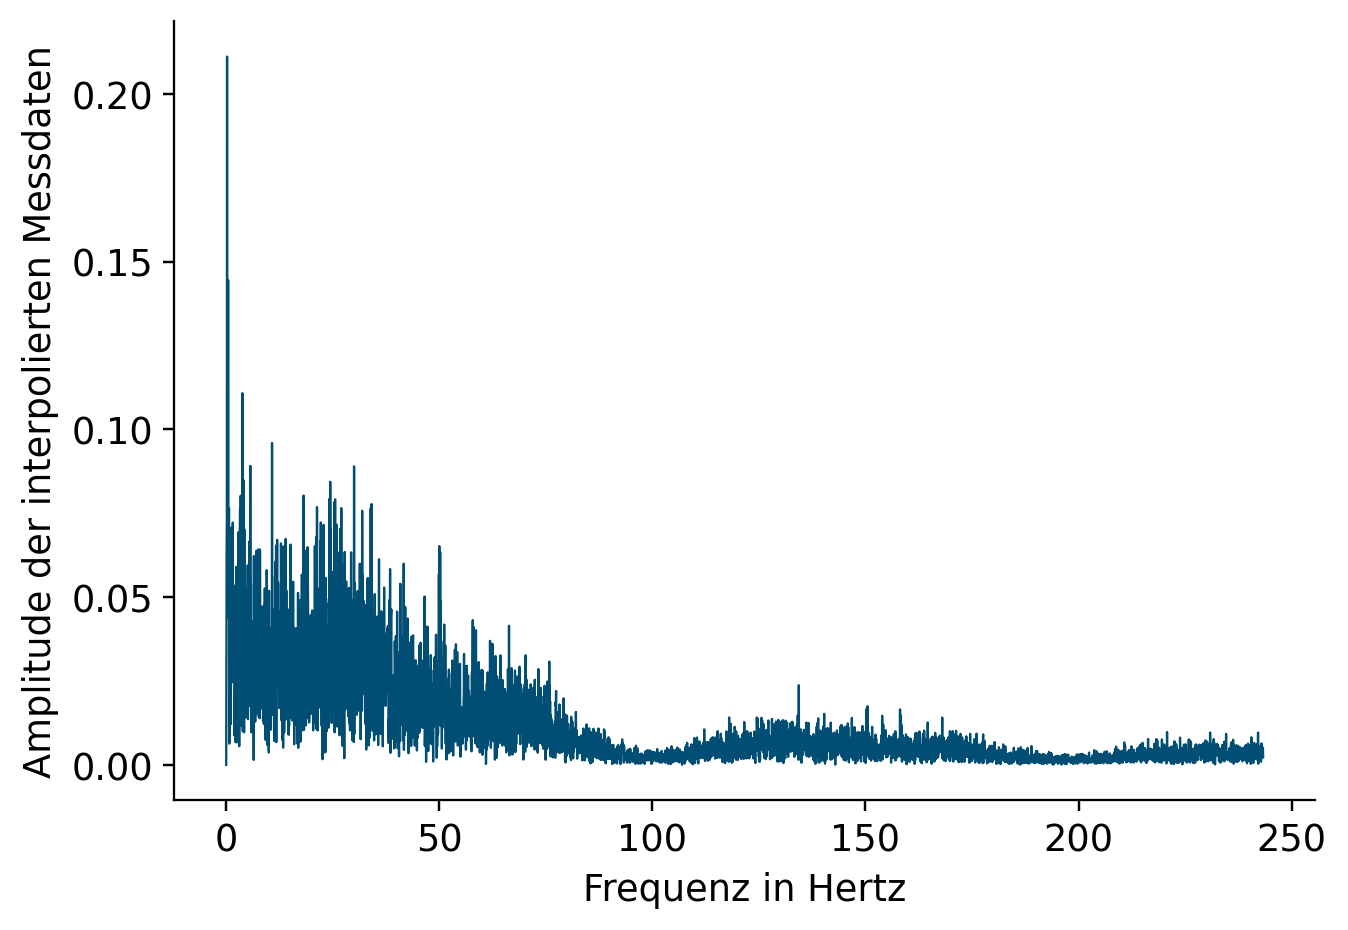

In [14]:
X_oneside, f_oneside = my_fft(daten_interpoliert, time)

fig2 = plt.figure()
plt.plot(f_oneside, np.abs(X_oneside))
plt.xlabel('Frequenz in Hertz')
plt.ylabel('Amplitude der interpolierten Messdaten')

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Insgesamt konnte man beide Messungen ohne große Schwierigkeiten durchführen und ist zu plausiblen Messergebnissen gekommen. Die Beschleunigungen beider Geräte liegen in einem ähnlichen Bereich. Auffällig sind die Ausreißer mancher Zeitschritte. Sprich der Raspberry Pi hat nicht immer die exakt gleichen Messintervalle eingehalten und es kommt zu Abweichungen. 

Die Amplitude des Ventilators nach der Fouriertransformation zeigt teilweise größere Sprünge und Ausreißer als die der Brotschneidemaschine. Vermutlich resultiert dies aus der Befestigung des Sensors am Ventilator. Da sich dieser noch zusätzlich bewegt, konnte der Sensor seine Position immer geringfügig ändern, was in Beschleunigungssprüngen resultiert. Insgesamt sind die Werte der Amplitude der Brotschneidemaschine etwas größer, jedoch gleichmäßiger. Dies könnte eventuell an der Unwucht des Sägeblatts liegen. Diese taucht in gleichmäßigen Zeitschritten immer wieder auf.

Um die Beschleunigungen besser analysieren zu können, müsste man ein genaueres Messgerät verwenden und die Sensoren besser an den Proben befestigen. So könnte man vermutlich bei dem Ventilatorversuch einige Amplitudensprünge und Abweichungen eliminieren.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Insgesamt hat mir der Versuch Spaß gemacht, da ich zu Beginn nicht vermutet hätte, bei den von mir ausgewählten Geräten wirklich starke Beschleunigungssprünge feststellen zu können. Außerdem habe ich im Studium bisher noch keinen wirklichen Kontakt zu Beschleunigungsmessungen gehabt bzw. war mit dem Messprinzip noch nicht vertraut. Zum besseren Verständnis konnte der Versuch hier auf jeden Fall beitragen. Auch von dem Ergebnis der Messungen war ich überrascht, da bei beiden Geräten doch gewisse Ausreißer vorhanden sind. Diese habe ich im Betrieb der Geräte vorher nicht wirklich wahrnehmen können. Auch diese Erkenntnis ist mir neu. Ich würde den Versuch als erfolgreich ansehen, da es mit gelungen ist, die Beschleunigungen von zwei Haushaltsgeräten zu messen und zu visualisieren.